In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [3]:
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from sustaingym.envs.evcharging import EVChargingEnv, GMMsTraceGenerator, RealTraceGenerator
from sustaingym.algorithms.evcharging.baselines import GreedyAlgorithm, RandomAlgorithm, RLAlgorithm, MPC


# Analyze Baselines

In [4]:
# Read results from file
from collections import defaultdict
from datetime import datetime
import os
import pickle

import numpy as np

from sustaingym.envs.evcharging.utils import DATE_FORMAT

periods = {'summer2019': 'summer 2019',
        #    'fall2019': 'fall 2019',
        #    'spring2020': 'spring 2020',
           'summer2021': 'summer 2021'
}

algorithms = {
    # 'ga2': 'greedy',
    # 'ra1': 'random',  # raw
    'ra2': 'random',  # projected
    # 'mpc1': 'mpc1',
    # 'mpc2': 'mpc2',
    'mpc6': 'mpc6',
    # 'mpc12': 'mpc12',
    # 'mpc36': 'mpc36'
}

baselines = defaultdict(dict)

for lbl in algorithms:
    for season in periods:
        baselines_path = os.path.join(os.getcwd(), 'logs/baselines')
        save_path = os.path.join(baselines_path, lbl, season)
        with open(os.path.join(save_path, 'test_results.pkl'), 'rb') as f:
            results = pickle.load(f)  # 'rewards', 'breakdown'
            rewards, breakdown = results['rewards'], results['breakdown']
        baselines[season][lbl] = results

Rewards from summer2019
random: 6.13 +/- 3.69
mpc6: 7.51 +/- 4.17
Rewards from summer2021
random: 1.59 +/- 1.05
mpc6: 2.22 +/- 1.47


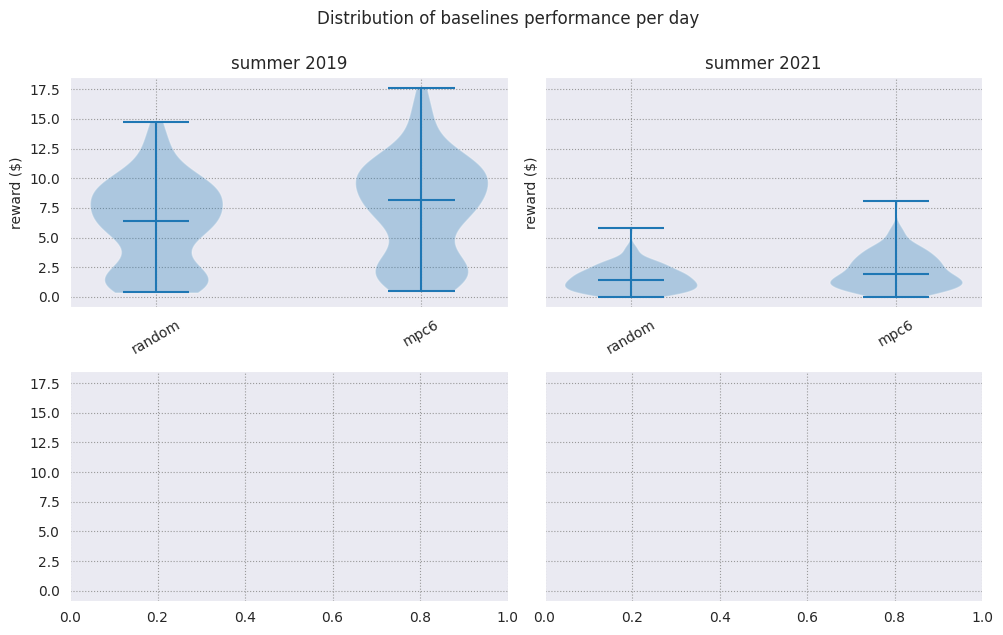

In [5]:
baselines_comp_algorithms = algorithms.copy()

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10, 6))
for i, period in enumerate(periods):
    print(f'Rewards from {period}')
    for lbl in baselines_comp_algorithms:
        rews = baselines[period][lbl]['rewards']
        print(f'{baselines_comp_algorithms[lbl]}: {np.mean(rews):.2f} +/- {np.std(rews):.2f}')
    row, col = i // 2, i % 2
    data = [baselines[period][lbl]['rewards'] for lbl in baselines_comp_algorithms]
    ax[row][col].violinplot(data, showmedians=True)
    ax[row][col].set_ylabel('reward ($)')
    ax[row][col].set_title(periods[period])
    x = np.arange(1, 1 + len(baselines_comp_algorithms))  # the label locations
    ax[row][col].set_xticks(x, baselines_comp_algorithms.values(), rotation=30)
fig.tight_layout()
fig.suptitle('Distribution of baselines performance per day', y=1.05)

# plt.savefig('algo_comp.png', dpi=300)
plt.show()

In [6]:
# x = np.arange(len(baselines_comp_algorithms))  # the label locations
# width = 0.35 * 2 / 2  # the width of the bars

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
# for i, period in enumerate(periods):
#     bdowns = {'profit': [], 'carbon_cost': [], 'excess_charge': []}
#     for lbl in baselines_comp_algorithms:
#         breakdown = baselines[period][lbl]['breakdown']
#         for comp in bdowns:
#             bdowns[comp].append(breakdown[comp])

#     row, col = i // 2, i % 2
#     ax1 = ax[row][col]
#     ax2 = ax1.twinx()

#     rects1 = ax1.bar(x - width, bdowns['profit'], width, label='profit', color='tab:blue')
#     rects2 = ax2.bar(x, bdowns['carbon_cost'], width, label='carbon_cost', color='tab:orange')
#     # rects3 = ax1.bar(x + width, bdowns['excess_charge'], width, label='excess_charge')  # 0

#     ax1.set_ylim(0, 1400)
#     ax2.set_ylim(0, 350)
#     ax1.set_ylabel('profit ($)')
#     ax2.set_ylabel('carbon cost ($)')
#     ax1.set_title(f'{period}')
#     ax1.set_xticks(x, baselines_comp_algorithms)

# fig.tight_layout()
# fig.suptitle('Baselines reward breakdown', y=1.05)

# # plt.savefig('algo_comp.png', dpi=300)
# plt.show()

# Analyze Training Curve

In [6]:
# groups = {
#     ('summer2019', 'ppo', 'discrete'): [101, 102, 103],
#     ('spring2020', 'ppo', 'discrete'): [111, 112, 113],
#     ('summer2021', 'ppo', 'discrete'): [121, 122, 123],
#     ('summer2019', 'ppo', 'continuous'): [151, 152, 153],
#     ('spring2020', 'ppo', 'continuous'): [161, 162, 163],
#     ('summer2021', 'ppo', 'continuous'): [171, 172, 173],
#     ('summer2019', 'a2c', 'discrete'): [201, 202, 203],
#     ('spring2020', 'a2c', 'discrete'): [211, 212, 213],
#     ('summer2021', 'a2c', 'discrete'): [221, 222, 223],
#     ('summer2019', 'a2c', 'continuous'): [251, 252, 253],
#     ('spring2020', 'a2c', 'continuous'): [261, 262, 263],
#     ('summer2021', 'a2c', 'continuous'): [271, 272, 273],
# }

groups = {  # (train period, model, project_action_in_env)
    ('summer2019', 'ppo', True): [301, 302, 303],
    ('summer2019', 'a2c', True): [401, 402, 403],
    ('summer2021', 'ppo', True): [321, 322, 323],
    ('summer2021', 'a2c', True): [421, 422, 423],
}

experiment_periods = ['summer2019', 'spring2020', 'summer2021']

# find best trial run in group
for group in groups:
    best_trial, best_reward = 0, -10000
    for trial in groups[group]:
        evals = np.load(f'logs/{group[1]}/exp_{trial}/summer2021/evaluations.npz')
        res = np.mean(evals['results'], axis=1)
        if res[-1] > best_reward:
            best_trial, best_reward = trial, res[-1]
        timesteps = evals['timesteps']
    groups[group] = best_trial

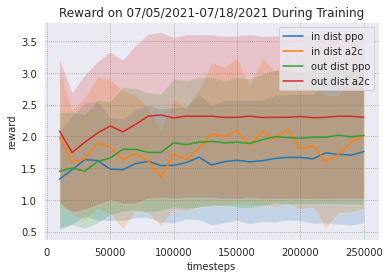

In [5]:
def reward_curve_all():
    # reward curve w/o action projection on 2-week sample in period
    for group in groups:
        evals = np.load(f'logs/{group[1]}/exp_{groups[group]}/summer2021/evaluations.npz')
        timesteps, results = evals['timesteps'], evals['results']
        y, error = np.mean(results, axis=1), np.std(results, axis=1)

        if group[0] == 'summer2019':
            lbl = f'in dist {group[1]}'
        else:
            lbl = f'out dist {group[1]}'
        plt.plot(timesteps, y, label=lbl)
        plt.fill_between(timesteps, y-error, y+error, alpha=0.2)
    plt.title(f'Reward on 07/05/2021-07/18/2021 During Training')
    plt.xlabel('timesteps')
    plt.ylabel('reward')
    plt.legend()
    plt.savefig('plots/training_curves_all.png', dpi=300)
    plt.show()

reward_curve_all()

['timesteps', 'results', 'profit', 'carbon_cost', 'excess_charge']
['timesteps', 'results', 'profit', 'carbon_cost', 'excess_charge']
['timesteps', 'results', 'profit', 'carbon_cost', 'excess_charge']
['timesteps', 'results', 'profit', 'carbon_cost', 'excess_charge']


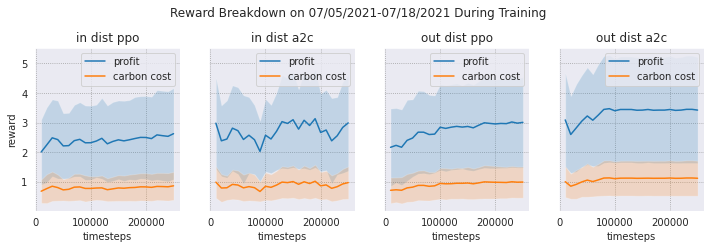

In [7]:
def reward_curve_separate():
    # reward curve w/o action projection on 2-week sample in period
    fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
    for i, group in enumerate(groups):
        evals = np.load(f'logs/{group[1]}/exp_{groups[group]}/summer2021/evaluations.npz')
        print([k for k, _ in evals.items()])
        timesteps, results = evals['timesteps'], evals['results']
        profit, carbon_cost = evals['profit'], evals['carbon_cost']

        profit, profit_err = np.mean(profit, axis=1), np.std(profit, axis=1)
        carbon_cost, cc_err = np.mean(carbon_cost, axis=1), np.std(carbon_cost, axis=1)

        if group[0] == 'summer2019':
            lbl = f'in dist {group[1]}'
        else:
            lbl = f'out dist {group[1]}'
        
        axes[i].plot(timesteps, profit, label='profit')
        axes[i].fill_between(timesteps, profit-profit_err, profit+profit_err, alpha=0.2)
        axes[i].plot(timesteps, carbon_cost, label='carbon cost')
        axes[i].fill_between(timesteps, carbon_cost-cc_err, carbon_cost+cc_err, alpha=0.2)
        axes[i].set_xlabel('timesteps')
        axes[0].set_ylabel('reward')
        axes[i].legend()
        
        axes[i].set_title(lbl)
    fig.suptitle(f'Reward Breakdown on 07/05/2021-07/18/2021 During Training', y=1.07)
    plt.savefig('plots/training_curves_separate.png', dpi=300, bbox_inches='tight')
    plt.show()

reward_curve_separate()

# Analyze RL Performance on Test Periods

In [15]:
# Line plot of performance over 123 days comparing ppo, a2c, greedy, and mpc6

def retrieve_test_results(rl_alg, exp, season, projected=True):
    if projected:
        eval_type = 'projection'
    else:
        eval_type = 'raw'
    res = f'logs/{rl_alg}/exp_{exp}/{eval_type}/{season}/test_results.pkl'
    with open(res, 'rb') as f:
        return pickle.load(f)

def plot_performance(train_season, action_type, test_season, projected=True, random_projected=True):
    if random_projected:
        lbls = {'ra2': 'random', 'mpc6': 'mpc6'}
    else:
        lbls = {'ra1': 'random', 'mpc6': 'mpc6'}

    rewards = {baseline: (0, 0) for baseline, v in lbls.items()}
    for baseline in lbls:
        rewards[baseline] = np.array(baselines[test_season][baseline]['rewards'])
    
    for rl_alg in ['ppo', 'a2c']:
        for train_season in ['summer2019', 'summer2021']:
            lbl = f'in dist {rl_alg}'
            if train_season == 'summer2019':
                lbl = f'in dist {rl_alg}'
            else:
                lbl = f'out dist {rl_alg}'
            lbls[lbl] = lbl

            group = (train_season, rl_alg, True)
            results = retrieve_test_results(rl_alg, groups[group], test_season, projected=True)
            print(len(results['rewards']))
            rewards[lbl] = results['rewards']
    data = [rewards[lbl] for lbl in lbls]

    xlabels = lbls.values()
    x_pos = np.arange(1, 1 + len(lbls))
    plt.xticks(x_pos, xlabels)
    plt.violinplot(data, showmedians=True)
    plt.ylabel('daily reward ($)') 
    plt.tight_layout()
    plt.savefig('plots/rl_performance.png', dpi=300)
    plt.show()


In [21]:
groups[('summer2019', 'ppo', True)]
groups[('summer2021', 'ppo', True)]

303

In [11]:
def retrieve_rewards_from_path(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# plot 2021

mpc6 = retrieve_rewards_from_path('logs/baselines/mpc6/summer2021/test_results.pkl')['rewards']
rand = retrieve_rewards_from_path('logs/baselines/ra3/summer2021/test_results.pkl')['rewards']
rand_discrete = retrieve_rewards_from_path('logs/baselines/ra2/summer2021/test_results.pkl')['rewards']

ppo_exp_2019 = groups[('summer2019', 'ppo', True)]
ppo_exp_2021 = groups[('summer2021', 'ppo', True)]
a2c_exp_2019 = groups[('summer2019', 'a2c', True)]
a2c_exp_2021 = groups[('summer2021', 'a2c', True)]
ppo2019 = retrieve_rewards_from_path(f'logs/ppo/exp_{ppo_exp_2019}/projection/summer2021/test_results.pkl')['rewards']
ppo2021 = retrieve_rewards_from_path(f'logs/ppo/exp_{ppo_exp_2021}/projection/summer2021/test_results.pkl')['rewards']
a2c2019 = retrieve_rewards_from_path(f'logs/a2c/exp_{a2c_exp_2019}/projection/summer2021/test_results.pkl')['rewards']
a2c2021 = retrieve_rewards_from_path(f'logs/a2c/exp_{a2c_exp_2021}/projection/summer2021/test_results.pkl')['rewards']

algorithm_to_rewards = {
    ('mpc6', 2021): mpc6,
    ('rand', 2021): rand,
    ('rand discrete', 2021): rand_discrete,
    ('PPO', 2019): ppo2019,
    ('PPO', 2021): ppo2021,
    ('A2C', 2019): a2c2019,
    ('A2C', 2021): a2c2021,
}

rows = []
for (alg, year), rewards in algorithm_to_rewards.items():
    rows.extend([(alg, year, r) for r in rewards])

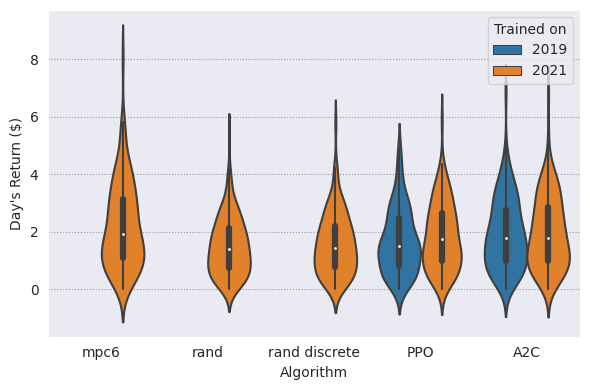

In [14]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

df = pd.DataFrame.from_records(rows, columns=['alg', 'year', 'return'])
sns.violinplot(data=df, x='alg', y='return', hue='year', ax=ax)
ax.set(xlabel='Algorithm', ylabel="Day's Return ($)")
ax.get_legend().set_title('Trained on')

123
123
123
123


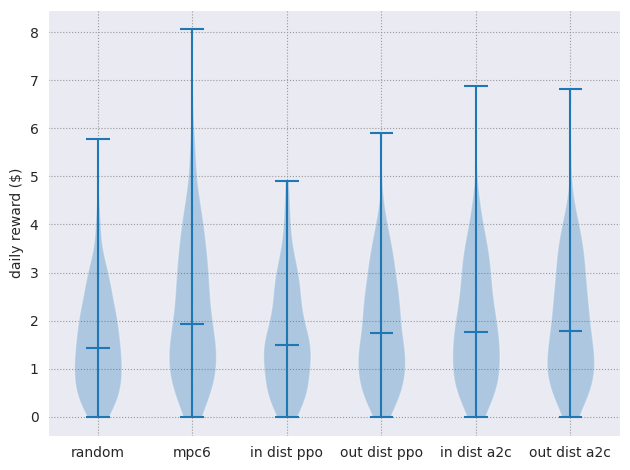

In [10]:
plot_performance('summer2019', 'discrete', 'summer2021')